## NN HPI Experiments

Generates neural net HPIs on King County data and saves them to CSV files. Requires hpiPy to be installed.

In [2]:
import pathlib, sys
sys.path.insert(1, str(pathlib.Path().resolve().parents[0]))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import copy
import os
import pickle
from datetime import datetime

import altair as alt
import numpy as np
import pandas as pd

from hpipy.extensions import NeuralNetworkIndex, RandomForestIndex
from hpipy.period_table import PeriodTable
from hpipy.price_index import HedonicIndex, RepeatTransactionIndex
from hpipy.trans_data import HedonicTransactionData, RepeatTransactionData
from hpipy.utils.metrics import (
    accuracy,
    revision,
    series_accuracy,
    series_volatility,
    volatility,
)
from hpipy.utils.plotting import (
    plot_index,
    plot_index_accuracy,
    plot_index_volatility,
    plot_series_revision,
    plot_series_volatility,
)

alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

In [4]:
df_sales = pd.read_csv('../data/kingco_sales.csv', index_col=0, parse_dates=['sale_date'])

## Prepare Data

In [5]:
def prep_kc_data(df_sales):
    df = df_sales.copy()

    # Remove sales with 'bad' status.
    allowed_status = ["new", "nochg", "rebuilt - before", "reno - before"]
    df = df[df["join_status"].isin(allowed_status)].copy()

    df["baths"] = df["bath_full"] + (df["bath_3qtr"] * 0.75) + (df["bath_half"] * 0.5)
    df["garage_sqft"] = df["garb_sqft"] + df["gara_sqft"]
    df["view_score"] = (
        df["view_rainier"]
        + df["view_olympics"]
        + df["view_cascades"]
        + df["view_sound"]
        + df["view_lakewash"]
    )
    df["tax_value"] = df["land_val"] + df["imp_val"]

    def waterfront_type(row):
        """Waterfront type."""
        if row["wfnt"] in [4, 5, 8]:
            return "lake"
        elif row["wfnt"] in [1, 9]:
            return "river"
        elif row["wfnt"] in [2, 3]:
            return "puget_sound"
        elif row["wfnt"] == 6:
            return "lake_wash"
        elif row["wfnt"] == 7:
            return "lake_samm"
        else:
            return "none"

    df["waterfront_type"] = df.apply(waterfront_type, axis=1)
    df["is_wfnt"] = df["wfnt"].apply(lambda x: 0 if x == 0 else 1)
    df["age"] = (df["sale_date"].dt.year - df["year_built"]).clip(lower=0)

    def effective_age(row):
        if row["year_reno"] == 0:
            return row["age"]
        else:
            return row["sale_date"].year - row["year_reno"]

    df["eff_age"] = df.apply(effective_age, axis=1)
    df["green_adjacent"] = df.apply(
        lambda row: 1 if row["golf"] == 1 or row["greenbelt"] == 1 else 0, axis=1
    )
    df["townhome"] = df["present_use"].apply(lambda x: 1 if x == 29 else 0)

    columns_to_select = [
        "sale_id",
        "pinx",
        "sale_date",
        "sale_price",
        "join_status",
        "latitude",
        "longitude",
        "city",
        "area",
        "submarket",
        "subdivision",
        "present_use",
        "land_val",
        "imp_val",
        "year_built",
        "year_reno",
        "age",
        "eff_age",
        "sqft_lot",
        "sqft",
        "grade",
        "condition",
        "stories",
        "beds",
        "baths",
        "garb_sqft",
        "gara_sqft",
        "waterfront_type",
        "is_wfnt",
        "golf",
        "greenbelt",
        "noise_traffic",
        "view_score",
    ]
    df = df[columns_to_select]

    # Fix Vashon Island submarket.
    df["submarket"] = df.apply(lambda x: "I" if x["submarket"] == "H" else x["submarket"], axis="columns")

    return df


df = prep_kc_data(df_sales)
df.to_csv("../data/king_df.csv", index=False)

## Prepare Experiments

In [6]:
def prep_kc_exp():
    """Create standard experiments (those with different time coverage)."""
    sales_df = pd.read_csv("../data/king_df.csv", parse_dates=["sale_date"])

    # Set experiment parameters.
    terminal_year = 2024
    time_ranges = [5, 10, 20]
    sms = ["county", "submarket"]
    periodicity = "monthly"
    train_per = 0.2

    # For HED/RF.
    ind_var = [
        "age",
        "baths",
        "beds",
        "grade",
        "latitude",
        "longitude",
        "present_use",
        "sqft",
        "sqft_lot",
        "submarket",
    ]

    # For RF only.
    rf_par = {
        "num_estimators": 200,
        "sim_per": 0.10,
        "min_bucket": 5,
    }

    nn_par = {
        "preprocess_geo": True,
        "feature_dict": {
            "numerics": [],
            "log_numerics": ["age", "sqft", "sqft_lot"],
            "categoricals": ["present_use", "submarket"],
            "ordinals": ["baths", "beds", "grade"],
            "hpi": ["sale_date"],
        },
    }

    def calculate_train_period(tr, periodicity, train_per):
        """Calculate train period based on periodicity."""
        if periodicity == "monthly":
            return int(round(tr * 12 * train_per, 0))
        else:
            return int(round(tr * 52 * train_per, 0))

    # For each desired time range, build data.
    for tr in time_ranges:
        print(f"Building Experiment Object for time = {tr}")

        # Set up Experiment Control Object.
        exp_obj = {
            "name": f"exp_{tr}",
            "time": tr,
            "start_date": f"{terminal_year - tr}-01-01",
            "sms": sms,
            "periodicity": periodicity,
            "train_period": calculate_train_period(tr, periodicity, train_per),
            "ind_var": ind_var,
            "rf_par": rf_par,
            "nn_par": nn_par,
        }

        # Check for directory, create if not present.
        exp_dir = os.path.join("data", exp_obj["name"])
        if not os.path.exists(exp_dir):
            os.makedirs(exp_dir)

        exp_obj["rt_df"] = RepeatTransactionData(
            sales_df[sales_df["sale_date"] >= exp_obj["start_date"]].copy()
        ).create_transactions(
            prop_id="pinx",
            trans_id="sale_id",
            price="sale_price",
            date="sale_date",
            periodicity=exp_obj["periodicity"],
            seq_only=True,
            min_period_dist=exp_obj["train_period"],
        )

        exp_obj["hed_df"] = HedonicTransactionData(
            sales_df[sales_df["sale_date"] >= exp_obj["start_date"]].copy()
        ).create_transactions(
            prop_id="pinx",
            trans_id="sale_id",
            price="sale_price",
            date="sale_date",
            periodicity=exp_obj["periodicity"],
        )

        # Write data.
        exp_obj["rt_df"].trans_df.to_csv(
            os.path.join(exp_dir, "rt_df.csv"), index=False
        )
        exp_obj["hed_df"].trans_df.to_csv(
            os.path.join(exp_dir, "hed_df.csv"), index=False
        )

        # Save the experiment object.
        with open(os.path.join(exp_dir, "exp_obj.pkl"), "wb") as file:
            pickle.dump(exp_obj, file)


prep_kc_exp()

Building Experiment Object for time = 5
Building Experiment Object for time = 10
Building Experiment Object for time = 20


## Run Experiments

In [7]:
def exp_wrapper(
    exp_obj,
    partition="all",
    verbose=False,
    estimator="robust",
    log_dep=True,
    vol_window=3,
    index_only=False,
):
    """Experiment wrapper."""
    # Get the max period.
    max_period = max(exp_obj["rt_df"].trans_df["period_2"])

    # Estimate the indices.
    if verbose:
        print(f"Estimating index with {exp_obj['model']} model...\n")

    if exp_obj["model"] == "rt":
        hpi_obj = RepeatTransactionIndex.create_index(
            trans_data=exp_obj["rt_df"],
            estimator=estimator,
            log_dep=log_dep,
            max_period=max_period,
        )

    if exp_obj["model"] == "hed":
        hpi_obj = HedonicIndex.create_index(
            trans_data=exp_obj["hed_df"],
            estimator="base",
            log_dep=log_dep,
            dep_var="price",
            ind_var=exp_obj["ind_var"],
            max_period=max(exp_obj["hed_df"].trans_df["trans_period"]),
            smooth=True,
        )

    if exp_obj["model"] == "rf":
        hpi_obj = RandomForestIndex.create_index(
            trans_data=exp_obj["hed_df"],
            estimator="pdp",
            log_dep=log_dep,
            dep_var="price",
            ind_var=exp_obj["ind_var"],
            num_estimators=exp_obj["rf_par"]["num_estimators"],
            max_period=max(exp_obj["hed_df"].trans_df["trans_period"]),
            smooth=True,
        )

    if exp_obj["model"] == "nn":
        hpi_obj = NeuralNetworkIndex.create_index(
            trans_data=exp_obj["hed_df"],
            date="sale_date",
            # estimator='attributional',
            estimator="residual",
            dep_var="price",
            ind_var=exp_obj["ind_var"],
            max_period=max(exp_obj["hed_df"].trans_df["trans_period"]),
            smooth=False,
            preprocess_geo=exp_obj["nn_par"]["preprocess_geo"],
            feature_dict=exp_obj["nn_par"]["feature_dict"],
            verbose=False,
        )

    # Extract into a data frame.
    index_df = pd.DataFrame(
        {
            "period": hpi_obj.periods,
            "value": hpi_obj.value,
            "imputed": hpi_obj.imputed,
            "time": exp_obj["time"],
            "model": exp_obj["model"],
            "exp": exp_obj["name"],
            "partition": partition,
        }
    )

    if index_only:
        return index_df

    if exp_obj["model"] == "nn":
        train_period = exp_obj["train_period"]
        max_period = max(exp_obj["hed_df"].trans_df["trans_period"])
        print(f"Running series ({train_period} to {max_period})...\n")
        series_obj = hpi_obj.create_series(
            train_period=train_period, max_period=max_period
        )

        series_df = []
        for i, hpi_i_obj in enumerate(series_obj.hpis):
            index_i_df = pd.DataFrame(
                {
                    "period": hpi_i_obj.periods,
                    "value": hpi_i_obj.value,
                    "imputed": hpi_i_obj.imputed,
                    "time": exp_obj["time"],
                    "model": exp_obj["model"],
                    "exp": exp_obj["name"],
                    "partition": partition,
                    "train_period": exp_obj["train_period"] + i,
                }
            )
            series_df.append(index_i_df)
        series_df = pd.concat(series_df)
    else:
        series_df = None

    return {
        "index": index_df,
        "series": series_df,
    }


def read_experiment_object(exp_path):
    with open(exp_path, "rb") as file:
        return pickle.load(file)


def run_experiments(exp_name, models):
    """Main experiment function."""
    exp_dir = os.path.join("data", exp_name)
    exp_obj_path = os.path.join(exp_dir, "exp_obj.pkl")

    exp_obj = read_experiment_object(exp_obj_path)

    for model in models:
        # Full County
        print(f"------ {model} --- {exp_name} --- all -----------------")
        exp_obj["model"] = model
        exp_obj["partition"] = "all"
        results_obj = exp_wrapper(exp_obj, partition="all", index_only=False)

        # Saving results.
        with open(os.path.join(exp_dir, f"{model}_all_results.pkl"), "wb") as file:
             pickle.dump(results_obj, file)

        # Submarkets.
        exp_obj_s = copy.deepcopy(exp_obj)
        exp_obj_s["ind_var"] = [
            "age",
            "baths",
            "beds",
            "grade",
            "latitude",
            "longitude",
            "present_use",
            "sqft",
            "sqft_lot",
        ]
        for submarket in sorted(df["submarket"].unique()):
            print(f"------ {model} --- {exp_name} --- submarket_{submarket} -----------------")
            exp_obj_i = copy.deepcopy(exp_obj_s)
            exp_obj_i["model"] = model
            exp_obj_i["partition"] = f"submarket_{submarket}"
            ss_ids = exp_obj_i["hed_df"].trans_df.query(f"submarket == '{submarket}'")["trans_id"].to_list()
            exp_obj_i["hed_df"].trans_df = exp_obj_i["hed_df"].trans_df.query(f"trans_id in {ss_ids}")
            for dtype in exp_obj["nn_par"]["feature_dict"].keys():
                exp_obj_i["nn_par"]["feature_dict"][dtype] = list(
                    set(exp_obj_i["nn_par"]["feature_dict"][dtype]).intersection(
                        exp_obj_i["ind_var"] + ["sale_date"]
                    )
            )
            results_obj = exp_wrapper(exp_obj_i, partition=f"submarket_{submarket}", index_only=False)
            with open(os.path.join(exp_dir, f"{model}_submarket_{submarket}_local_results.pkl"), "wb") as file:
                 pickle.dump(results_obj, file)


# Define experiment parameters.
# time_frames = ['exp_5', 'exp_10', 'exp_20']
time_frames = ["exp_10"]
# models = ['rt', 'hed', 'rf', 'nn']
models = ["nn"]

# Run experiments for each time frame.
for exp in time_frames:
    run_experiments(exp, models)

------ nn --- exp_10 --- all -----------------
Running series (24 to 120)...

------ nn --- exp_10 --- submarket_D -----------------
Running series (24 to 120)...

------ nn --- exp_10 --- submarket_R -----------------
Running series (24 to 120)...

------ nn --- exp_10 --- submarket_I -----------------
Running series (24 to 120)...

------ nn --- exp_10 --- submarket_F -----------------
Running series (24 to 120)...

------ nn --- exp_10 --- submarket_N -----------------
Running series (24 to 120)...

------ nn --- exp_10 --- submarket_S -----------------
Running series (24 to 120)...

------ nn --- exp_10 --- submarket_O -----------------
Running series (24 to 120)...

------ nn --- exp_10 --- submarket_C -----------------
Running series (24 to 120)...

------ nn --- exp_10 --- submarket_Q -----------------
Running series (24 to 120)...

------ nn --- exp_10 --- submarket_B -----------------
Running series (24 to 120)...

------ nn --- exp_10 --- submarket_J -----------------
Running

## Save Experiments

In [8]:
# exps = ['exp_5', 'exp_10', 'exp_20']
exps = ["exp_10"]

indices = []
series = []
for exp in exps:
    exp_dir = os.path.join("data", exp)
    resfiles = [f for f in os.listdir(exp_dir) if f.endswith("_all_results.pkl")]
    for res in resfiles:
        print(os.path.join(exp_dir, res))
        with open(os.path.join(exp_dir, res), "rb") as file:
            x = pickle.load(file)
        if "index" in list(x.keys()):
            if x["index"]["model"].iloc[0] == "nn":
                indices.append(x["index"])
                series.append(x["series"])
        elif x["model"].iloc[0] == "nn":
            indices.append(x)
df_indices = pd.concat(indices)
df_indices.to_csv("exp_nn_results_py.csv", index=False)
if series:
    df_series = pd.concat(series)
    df_series.to_csv("exp_nn_series_results_py.csv", index=False)

data/exp_10/nn_all_results.pkl


In [9]:
# exps = ['exp_5', 'exp_10', 'exp_20']
exps = ["exp_10"]

indices = []
series = []
for exp in exps:
    exp_dir = os.path.join("data", exp)
    resfiles = [f for f in os.listdir(exp_dir) if f.endswith("_local_results.pkl")]
    for res in resfiles:
        print(os.path.join(exp_dir, res))
        with open(os.path.join(exp_dir, res), "rb") as file:
            x = pickle.load(file)
        if "index" in list(x.keys()):
            if x["index"]["model"].iloc[0] == "nn":
                indices.append(x["index"])
                series.append(x["series"])
        elif x["model"].iloc[0] == "nn":
            indices.append(x)
df_indices = pd.concat(indices)
df_indices.to_csv("exp_nn_submarkets_local_results_py.csv", index=False)
if series:
    df_series = pd.concat(series)
    df_series.to_csv("exp_nn_series_submarkets_local_results_py.csv", index=False)

data/exp_10/nn_submarket_A_local_results.pkl
data/exp_10/nn_submarket_D_local_results.pkl
data/exp_10/nn_submarket_E_local_results.pkl
data/exp_10/nn_submarket_C_local_results.pkl
data/exp_10/nn_submarket_F_local_results.pkl
data/exp_10/nn_submarket_B_local_results.pkl
data/exp_10/nn_submarket_G_local_results.pkl
data/exp_10/nn_submarket_P_local_results.pkl
data/exp_10/nn_submarket_N_local_results.pkl
data/exp_10/nn_submarket_K_local_results.pkl
data/exp_10/nn_submarket_Q_local_results.pkl
data/exp_10/nn_submarket_O_local_results.pkl
data/exp_10/nn_submarket_J_local_results.pkl
data/exp_10/nn_submarket_R_local_results.pkl
data/exp_10/nn_submarket_L_local_results.pkl
data/exp_10/nn_submarket_I_local_results.pkl
data/exp_10/nn_submarket_S_local_results.pkl
data/exp_10/nn_submarket_M_local_results.pkl


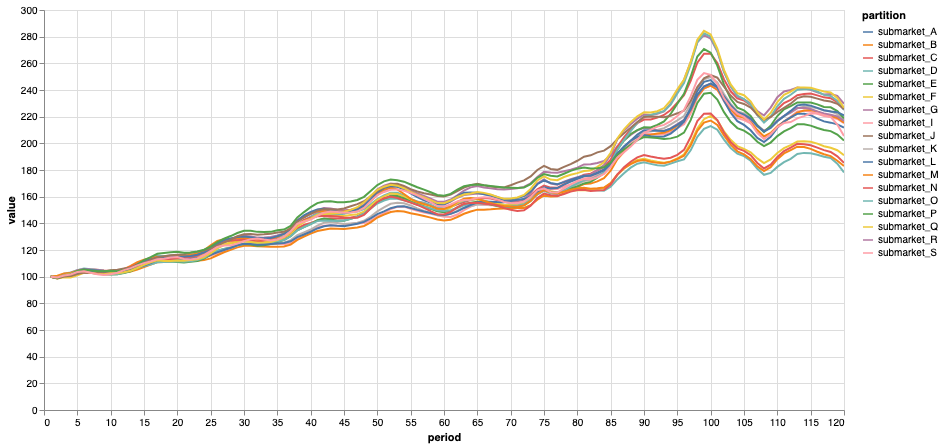

In [20]:
df_temp = pd.read_csv("/Users/reidj/Documents/GitHub/hpipy/notebooks/exp_nn_submarkets_global_results_py.csv")
#chart = alt.Chart(df_temp.query("partition != 'all'")).mark_line().encode(
chart = alt.Chart(df_temp).mark_line().encode(
    x=alt.X('period'), y=alt.Y('value'), color=alt.Color('partition'), tooltip=[alt.Tooltip('partition'), alt.Tooltip('value')]
).interactive().properties(height=400, width=800)
chart

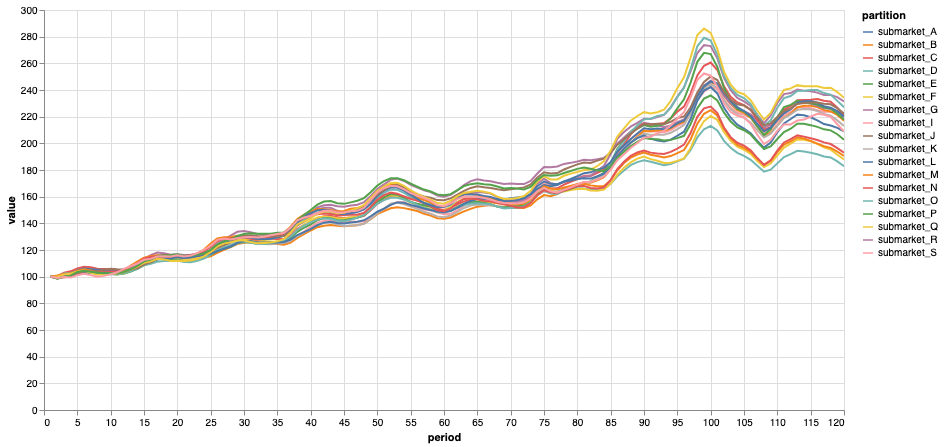

In [21]:
df_temp2 = pd.read_csv("/Users/reidj/Documents/GitHub/hpipy/notebooks/exp_nn_submarkets_global_results_py_bak.csv")
#chart = alt.Chart(df_temp.query("partition != 'all'")).mark_line().encode(
chart = alt.Chart(df_temp2).mark_line().encode(
    x=alt.X('period'), y=alt.Y('value'), color=alt.Color('partition'), tooltip=[alt.Tooltip('partition'), alt.Tooltip('value')]
).interactive().properties(height=400, width=800)
chart